In [7]:
import numpy as np
import torch
import torch.nn.functional as F
from livelossplot import PlotLosses
from torch.utils.data import DataLoader,TensorDataset
from tqdm import tqdm 
import torch.utils.data as data
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import cVAE

In [8]:
# TODO
# - reshape data in preprocessing step

In [9]:
train_path = 'data/Ferguson_fire_train.npy'
val_path = 'data/Ferguson_fire_test.npy'
test_path = 'data/Ferguson_fire_obs.npy'

In [10]:
def chunk(arr, chunk_size):
    L = len(arr)
    num_chunks = L // chunk_size
    remainder = L % chunk_size
    chunks = np.split(arr[:L-remainder], num_chunks)
    if remainder != 0:
        chunks.append(arr[L-remainder:])
    return chunks

def create_x_y(data,chunk_size): #reshape here + remove from train loop
    x = chunk(data,chunk_size)
    y = chunk(data,chunk_size)
    for i in range(len(x)):
        x[i] = x[i][:-1]
        y[i] = y[i][1:]
    return np.concatenate(x),np.concatenate(y)

In [11]:
# Load and process data

train_path = 'data/Ferguson_fire_train.npy'
val_path = 'data/Ferguson_fire_test.npy'
test_path = 'data/Ferguson_fire_obs.npy'

train_data = np.array(np.load(open(train_path,'rb')))
train_data_x, train_data_y = create_x_y(train_data, 100)
tensor_x = torch.Tensor(train_data_x)
tensor_y = torch.Tensor(train_data_y)
train_dataset = TensorDataset(tensor_x,tensor_y)

val_data = np.array(np.load(open(val_path,'rb')))
val_data_x, val_data_y = create_x_y(val_data, 100)
tensor_x = torch.Tensor(val_data_x)
tensor_y = torch.Tensor(val_data_y)
val_dataset = TensorDataset(tensor_x,tensor_y)

test_data = np.array(np.load(open(test_path,'rb')))
test_data_1D = np.reshape(test_data, (np.shape(test_data)[0],np.shape(test_data)[1]*np.shape(test_data)[2]))
test_data_1D_shifted = torch.Tensor(test_data_1D[1:])
test_data_1D = torch.Tensor(test_data_1D[:-1])
test_dataset = TensorDataset(test_data_1D,test_data_1D_shifted)

train_loader = data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*32, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*32, shuffle=False)

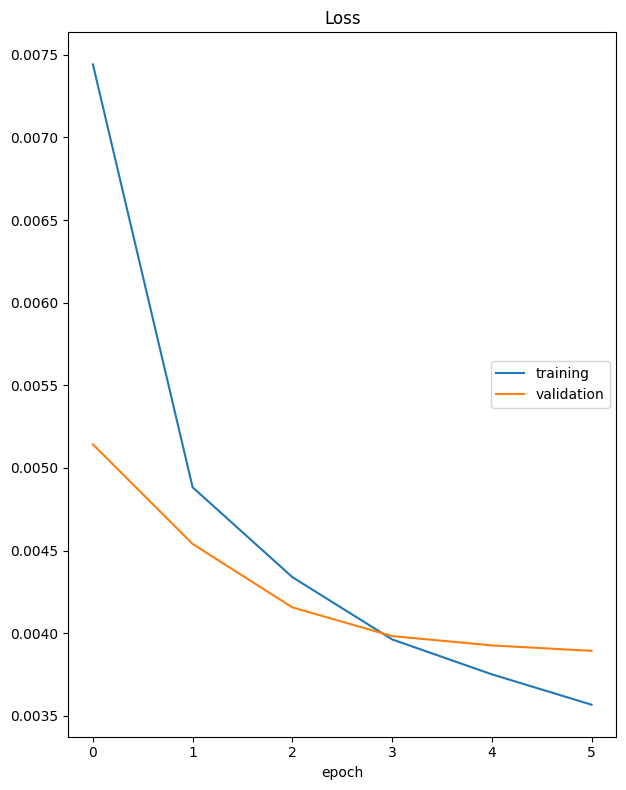

Loss
	training         	 (min:    0.004, max:    0.007, cur:    0.004)
	validation       	 (min:    0.004, max:    0.005, cur:    0.004)
Epoch 7 of 30
Train:


 65%|██████████████████████████▊              | 253/387 [09:59<04:59,  2.24s/it]

In [ ]:
def train(autoencoder, train_data, val_data, kl_div_on=True, epochs=10, device='cpu', patience=3):
    opt = torch.optim.Adam(autoencoder.parameters())
    loss_fn = nn.MSELoss()
    liveloss = PlotLosses()    
    best_val_loss = float('inf')
    counter = 0
    for epoch in range(epochs):
        print(f'Epoch {epoch+1} of {epochs}')
        logs = {}
        train_loss = 0.0
        val_loss = 0.0
        # Training
        autoencoder.train()
        print('Train:')
        for batch, label in tqdm(train_data):
            batch = batch.reshape(batch.shape[0], 1, batch.shape[1], batch.shape[2]).to(device)
            opt.zero_grad()
            x_hat, KL = autoencoder(batch)
            loss = loss_fn(x_hat.squeeze(), label)
            loss.backward()
            opt.step()
            train_loss += loss.item()
        train_loss /= len(train_data)
        logs['loss'] = train_loss
        # Validation
        autoencoder.eval()
        print('Val:')
        with torch.no_grad():
            for batch, label in tqdm(val_data):
                batch = batch.reshape(batch.shape[0], 1, batch.shape[1], batch.shape[2]).to(device)
                x_hat, KL = autoencoder(batch)
                loss = loss_fn(x_hat.squeeze(), label)
                val_loss += loss.item()
        val_loss /= len(val_data)
        logs['val_loss'] = val_loss
        liveloss.update(logs)
        liveloss.send()
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping: No improvement in validation loss for {patience} epochs.")
                break
    return autoencoder

device = 'cpu'
cvae = cVAE.VAE_Conv(device).to(device)
cvae = train(cvae, train_loader, val_loader, epochs=30, device=device)
torch.save(cvae.state_dict(), 'cvae.pt')

In [ ]:
images, labels = next(iter(train_loader))
cvae.eval()

_, ax = plt.subplots(2, 5, figsize=[18.5, 6])
for n, idx  in enumerate(torch.randint(0,images.shape[0], (5,))):
    recon, _ = cvae(images[idx].unsqueeze(0)) 
    ax[0, n].imshow(labels[idx].squeeze())
    ax[1, n].imshow(recon.cpu().detach().squeeze())

In [ ]:
# calculate mse between train and test here

In [ ]:
# display results on obs data here

In [ ]:
# calculate mse between actual obs data and predicted obs data here